<a href="https://colab.research.google.com/github/igorlysov/CP2022/blob/main/demin/notebook/Numba_CP2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Компьютерный практикум 2021-2022

## [Numba](http://numba.pydata.org/)

`Numba` is an open source JIT compiler that translates a subset of `Python` and `NumPy` code into fast machine code

`Numba` - это:
- компиляция во время выполнения, just-in-time compilation (JIT)
- компиляция для CPU и GPU
- автоматическое распараллеливание [OpenMP](https://en.wikipedia.org/wiki/OpenMP) and [SIMD](https://en.wikipedia.org/wiki/SIMD)
- кросс-платформенность
- кэширование компилированного кода
- компиляция заранее, ahead-of-time compilation (AOT)

### Как работает `Numba`:

функция `Python` $\rightarrow$ первый вызов функции $\rightarrow$ подстановка типов аргументов при первом вызове $\rightarrow$ промежуточное представление (IR) $\rightarrow$ компилятор [LLVM](https://llvm.org/) или компилятор [NVCC](https://en.wikipedia.org/wiki/Nvidia_CUDA_Compiler) $\rightarrow$ компилированная функция (машинный код CPU/GPU)

### Что мы будем использовать из модуля `Numba`:

- `@jit, @njit` - для компиляции основных функций
- `cfunc` - для компиляции callback-функций
- `prange` - для распараллеливания

### Использование декоратора `@jit`


Замечание:

`njit` $\equiv$ `jit(nopython=True)`

Декоратор без параметров
```
@jit
def my_func():
    # тело функции
```

Декоратор с параметрами
```
@jit(signature, nopython=True, cache=True, fastmath=True, boundscheck=False, ...)
def my_func():
    # тело функции
```

- `signature` - сигнатура или объявление функции, которое содержит тип возращаемого значения и типы всех аргументов

- `nopython = True` - компилировать в режиме nopython (этот режим мы будем использовать)

- `cache = True` - кэшировать компилированный код (работает только для функций, код которых записан в `*.py` файле)

- `fastmath = True` - оптимизировать некоторые математические операции; может ускорить вычисления, но некоторые операции могут выполняться с повышенной погрешностью

- `boundscheck = False` - отключить проверку выхода за границы массива (можно применять, если грамотно написаны циклы, либо использованы операции `Numpy`)


### Как писать код, чтобы получить быструю функцию с применением `jit`?

Простые правила, т.е. так сработает. Можно и по-другому, но это сложнее.

- Параметры `jit`
 - `nopython = True`, либо использование `njit`


- Типы аргументов:
    - числовые константы, True/False, None
    - массивы `Numpy`
    - именованные аргументы со значением по-умолчанию 
    - callback-функции (на данный момент `Numba` поддерживает только в экспериментальном режиме)
    
    
- Возвращаемое значение:
    - числовые константы, True/False
    - массивы `Numpy`
    - кортежи
    
    
- Тело функции:
    - арифметические выражения
    - ветвления
    - циклы `Python`
    - поддерживаемые функции и выражения `Numpy`
    - вызовы других `jit`-функций

In [ ]:
!pip install -U numpy matplotlib numba holoviews

     |████████████████████████████████| 15.7 MB 178 kB/s 
     |████████████████████████████████| 10.3 MB 59.3 MB/s 
     |████████████████████████████████| 3.4 MB 48.1 MB/s 
     |████████████████████████████████| 15.3 MB 171 kB/s 
     |████████████████████████████████| 26.3 MB 83 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the

In [ ]:
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange

### Построение изображения [множества Мандельброта](https://ru.wikipedia.org/wiki/Множество_Мандельброта)

Множество Мандельброта - множество точек $c$ комплексной плоскости, для которых рекуррентное соотношение $z_{n+1} = z_n^2 + c$ при $z_0 = 0$ задает ограниченную последовательность.

Цель расчета: построить изображение $16000 x 8000$ пикселей при максимальном количестве итераций рекуррентной формулы в $1000$

In [ ]:
nx, ny = 200, 100  # уменьшенная задача
nx_full, ny_full = 16000, 8000  # полная задача

In [ ]:
xmin, xmax = -1.5, 0.5
ymin, ymax = 0.0, 1.0
l, h = xmax - xmin, ymax - ymin

In [ ]:
# функция для расчета времени вычисления полной задачи
# на основе времени расчета уменьшенной

def calc_full_time(t, nx, ny, nx_full, ny_full):
    return t * (nx_full + 1) * (ny_full + 1) / (nx + 1) / (ny + 1)

### Прототип

In [ ]:
def mandelbrot_point_proto(c, maxit=1000):
    '''
    Вычисление количества итераций для точки c по рекуррентной формуле
    z(n+1) = z(n)**2 + c, z(0) = 0 при которых z(n+1) "уходит на бесконечность"
    '''
    z = 0
    for i in range(maxit):
        z = z**2 + c
        if abs(z) > 2:
            break
    return i

In [ ]:
def mandelbrot_proto(xmin, xmax, ymin, ymax, nx, ny, maxit=1000):
    '''
    Вычисление количества итераций для точек c, расположенных на решетке
    размером (nx, ny)
    '''

    dx = (xmax - xmin) / nx
    dy = (ymax - ymin) / ny
    res = []
    for iy in range(ny + 1):
        res.append([])
        for ix in range(nx + 1):
            x = xmin + dx * ix
            y = ymin + dy * iy
            it = mandelbrot_point_proto(x + 1j * y, maxit)
            res[-1].append(it)
    return res

In [ ]:
res_proto = mandelbrot_proto(xmin, xmax, ymin, ymax, nx, ny)

In [ ]:
n = 1
t_proto = timeit("mandelbrot_proto(xmin, xmax, ymin, ymax, nx, ny)", 
                 number = n, globals=globals()) / n
t_proto

1.958203340999944

In [ ]:
print(f"{calc_full_time(t_proto, nx, ny, nx_full, ny_full) / 60:.2f} мин")

205.82 мин


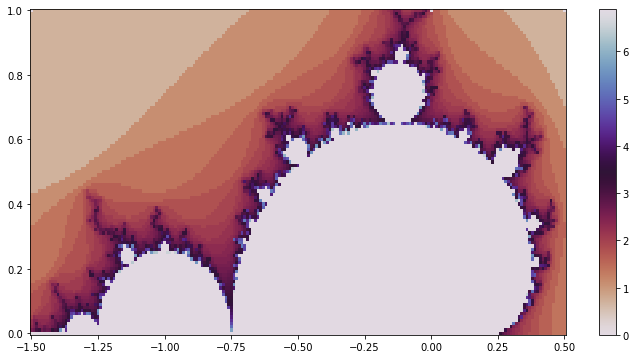

In [ ]:
r = 6.0
plt.figure(figsize=(l*r, h*r))
plt.pcolormesh(np.linspace(xmin, xmax, nx + 1), 
               np.linspace(ymin, ymax, ny + 1), 
               np.log(res_proto), cmap='twilight_r',
               shading='auto')
plt.colorbar();
#plt.axis('equal');

### Компиляция кода для одного ядра

- Использовать декоратор `@jit(nopython = True)` или `@njit`

- Переписать код для работы с массивами вместо списков

In [ ]:
@njit
def mandelbrot_point_njit(c, maxit=1000):
    z = 0
    for i in range(maxit):
        z = z**2 + c
        if abs(z) > 2:
            break
    return i

In [ ]:
# Если кажется, что достаточно только добавить декоратор njit,
# то Numba сразу дает понять, что это не так

@njit
def mandelbrot_njit(xmin, xmax, ymin, ymax, nx, ny, maxit=1000):
    dx = (xmax - xmin) / nx
    dy = (ymax - ymin) / ny
    res = []
    for iy in range(ny + 1):
        res.append([])
        for ix in range(nx + 1):
            x = xmin + dx * ix
            y = ymin + dy * iy
            it = mandelbrot_point_njit(x + 1j * y, maxit)
            res[-1].append(it)
    return res

In [ ]:
# запуск для компиляции

# По сообщению об ошибке трудно понять в чем дело.
# Посмотрев на Traceback можно увидеть:
# Something unsupported is present in the user code, add help info.
# А в самом низу Numba указывает на строку: res[-1].append(it).
# Это означает, что списки Python не поддерживаются и придется 
# переписывать код с использованием массивов.


mandelbrot_njit(xmin, xmax, ymin, ymax, 1, 1)

TypingError: ignored

In [ ]:
# функция, использующая двумерный массив вместо списков

@njit
def mandelbrot_njit(xmin, xmax, ymin, ymax, nx, ny):
    dx = (xmax - xmin) / nx
    dy = (ymax - ymin) / ny
    arr = np.empty((ny + 1, nx + 1), dtype=np.uint16)
    for iy in range(ny + 1):
        for ix in range(nx + 1):
            x = xmin + dx * ix
            y = ymin + dy * iy
            it = mandelbrot_point_njit(x + 1j * y)
            arr[iy, ix] = it
    return arr

In [ ]:
# запуск для компиляции (nx = ny = 1)
mandelbrot_njit(xmin, xmax, ymin, ymax, 1, 1)

array([[999,   4],
       [  1,   1]], dtype=uint16)

In [ ]:
# расчет уменьшенной задачи
res_njit = mandelbrot_njit(xmin, xmax, ymin, ymax, nx, ny)

In [ ]:
# проверка на совпадение результатов с прототипом
np.all(np.asarray(res_proto) == res_njit)

True

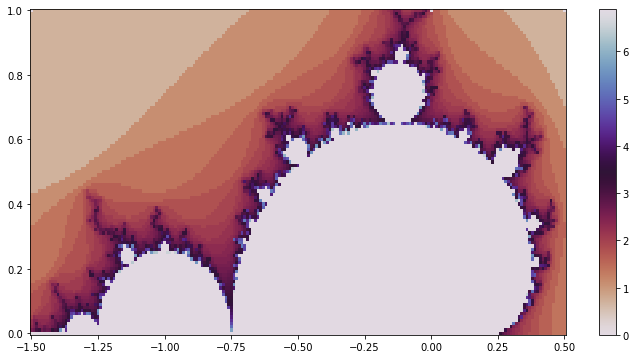

In [ ]:
r = 6.0
plt.figure(figsize=(l*r, h*r))
plt.pcolormesh(np.linspace(xmin, xmax, nx + 1), 
               np.linspace(ymin, ymax, ny + 1), 
               np.log(res_njit), cmap='twilight_r',
               shading='auto')
plt.colorbar();

In [ ]:
n = 10
t_njit = timeit("mandelbrot_njit(xmin, xmax, ymin, ymax, nx, ny)", 
                number = n, globals=globals()) / n
t_njit

0.10510158239999327

In [ ]:
print(f"{calc_full_time(t_njit, nx, ny, nx_full, ny_full) / 60:.2f} мин")

11.05 мин


### Распараллеливание в Numba

- Декоратор `jit`/`njit` должен быть снабжен аргументом `parallel = True`

- Во внешнем цикле вместо `range` необходимо использовать `prange`

In [ ]:
@njit(parallel = True)
def mandelbrot_parallel(xmin, xmax, ymin, ymax, nx, ny, maxit=1000):
    dx = (xmax - xmin) / nx
    dy = (ymax - ymin) / ny
    arr = np.empty((ny + 1, nx + 1), dtype=np.uint16)
    for iy in prange(ny + 1):
        for ix in range(nx + 1):
            x = xmin + dx * ix
            y = ymin + dy * iy
            it = mandelbrot_point_njit(x + 1j * y, maxit)
            arr[iy, ix] = it
    return arr

In [ ]:
# запуск на четырех точках для компиляции
mandelbrot_parallel(xmin, xmax, ymin, ymax, 1, 1)

array([[999,   4],
       [  1,   1]], dtype=uint16)

In [ ]:
n = 10
t_parallel = timeit("mandelbrot_parallel(xmin, xmax, ymin, ymax, nx, ny)", 
                     number = n, globals=globals()) / n
t_parallel

0.10918488329999718

In [ ]:
print(f"{calc_full_time(t_parallel, nx, ny, nx_full, ny_full) / 60:.2f} мин")

11.48 мин


In [ ]:
res_parallel = mandelbrot_parallel(xmin, xmax, ymin, ymax, nx, ny)

In [ ]:
# проверка на совпадение результатов с прототипом
np.all(np.asarray(res_proto) == res_parallel)

True

### Расчет полной задачи параллельной версией кода

In [ ]:
%%time
res_full = mandelbrot_parallel(xmin, xmax, ymin, ymax, nx_full, ny_full)

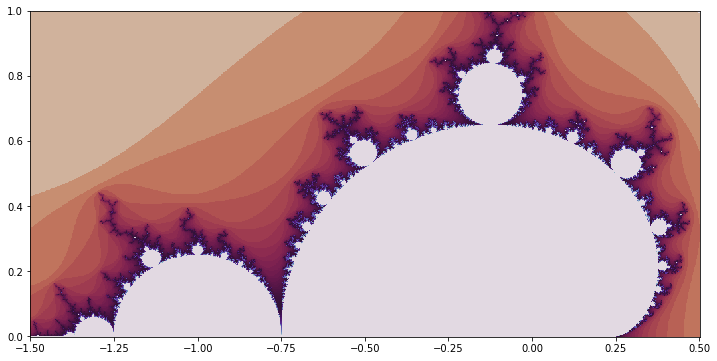

In [ ]:
# вывод изображения с шагом 16 по обоим измерениям (1000x500 пикселей)

r = 6.0
step = 16
plt.figure(figsize=(l*r, h*r))
x = np.linspace(xmin, xmax, nx_full + 1)
y = np.linspace(ymin, ymax, ny_full + 1)

plt.pcolormesh(x[::step], y[::step], np.log(res_full[::step, ::step]), 
               cmap='twilight_r',
               shading='auto')
#plt.colorbar();

### Визуализация всей карты и ее небольшого кусочка

In [ ]:
width, height = 600, 300
xstart, ystart = 800, 200
xstop, ystop = xstart + width, ystart + height

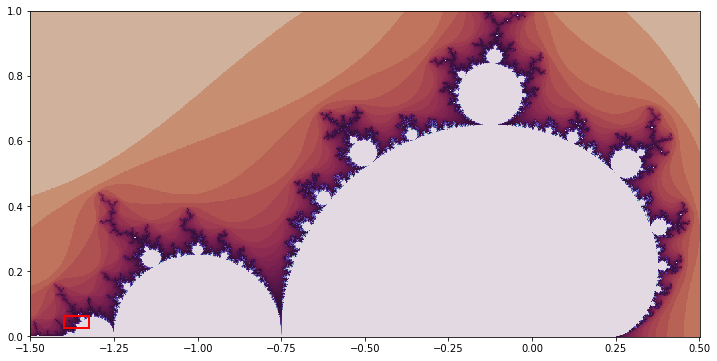

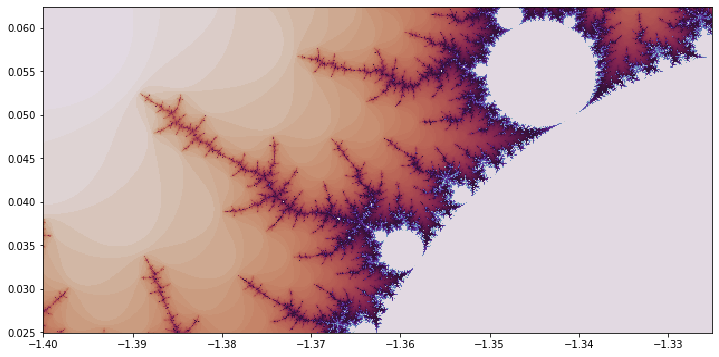

In [ ]:
r = 6.0

# карта с границей области зума

step = 16
plt.figure(figsize=(l*r, h*r))
x = np.linspace(xmin, xmax, nx_full + 1)
y = np.linspace(ymin, ymax, ny_full + 1)

plt.pcolormesh(x[::step], y[::step], np.log(res_full[::step, ::step]), 
               cmap='twilight_r',
               shading='auto')
rect = plt.Rectangle([x[xstart], y[ystart]], \
                     x[xstop] - x[xstart], 
                     y[ystop] - y[ystart],
                     fill = False, color='red', lw=2)
plt.gca().add_artist(rect)

#plt.colorbar();

# зумированная область

plt.figure(figsize=(l*r, h*r))
x = np.linspace(xmin, xmax, nx_full + 1)
y = np.linspace(ymin, ymax, ny_full + 1)

plt.pcolormesh(x[xstart:xstop], 
               y[ystart:ystop], 
               np.log(res_full[ystart:ystop, xstart:xstop]), 
               cmap='twilight_r',
               shading='auto')
#plt.colorbar();

### Оптимизация алгоритма (опциональный блок)

- избавление от расчетов с комплексными числами
- ускорение более 2 раз

In [ ]:
@njit(fastmath = True)
def mandelbrot_point_njit_v2(x0, y0, maxit=1000):
    x, y = 0, 0
    for i in range(maxit):
        x, y = x*x - y*y + x0, 2*x*y + y0
        if x*x + y*y > 4:
            break
    return i

@njit(parallel = True, fastmath = True)
def mandelbrot_parallel_v2(xmin, xmax, ymin, ymax, nx, ny, maxit=1000):
    dx = (xmax - xmin) / nx
    dy = (ymax - ymin) / ny
    arr = np.empty((ny + 1, nx + 1), dtype=np.uint16)
    for iy in prange(ny + 1):
        for ix in range(nx + 1):
            x = xmin + dx * ix
            y = ymin + dy * iy
            it = mandelbrot_point_njit_v2(x, y, maxit)
            arr[iy, ix] = it
    return arr

In [ ]:
# запуск на четырех точках для компиляции
mandelbrot_parallel_v2(xmin, xmax, ymin, ymax, 1, 1)

array([[999,   4],
       [  1,   1]], dtype=uint16)

In [ ]:
n = 100
t_parallel_v2 = timeit("mandelbrot_parallel_v2(xmin, xmax, ymin, ymax, nx, ny)", 
                     number = n, globals=globals()) / n
t_parallel_v2, t_parallel

(0.030206765209999275, 0.10918488329999718)

In [ ]:
print(f"v1: {calc_full_time(t_parallel, nx, ny, nx_full, ny_full) / 60:.2f} мин")
print(f"v2: {calc_full_time(t_parallel_v2, nx, ny, nx_full, ny_full) / 60:.2f} мин")

v1: 11.48 мин
v2: 3.17 мин


In [ ]:
res_parallel_v2 = mandelbrot_parallel_v2(xmin, xmax, ymin, ymax, nx, ny)

In [ ]:
# проверка на совпадение результатов с прототипом
np.all(np.asarray(res_proto) == res_parallel_v2)

False

In [ ]:
# при использовании fastmath = True результат не совпадает в трех точках
# для визуализации это допустимо

idx = np.where(np.asarray(res_proto) - res_parallel_v2)
idx

(array([ 55,  63, 100]), array([ 95, 115, 150]))

In [ ]:
res_parallel_v2[idx], np.asarray(res_proto)[idx]

(array([413, 999,  45], dtype=uint16), array([399, 761, 999]))

### Interactive plot

[Mandelbrot tutorial](https://holoviews.org/gallery/apps/bokeh/mandelbrot.html#apps-bokeh-gallery-mandelbrot)

[Image range tool](https://holoviews.org/gallery/demos/bokeh/image_range_tool.html#demos-bokeh-gallery-image-range-tool)

In [ ]:
%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


In [ ]:
import holoviews as hv

from holoviews import opts
from holoviews.streams import RangeXY


In [ ]:
imwidth, imheight = 600, 600
maxit = 200

# callback для пересчета изображения фрактала

def get_fractal(x_range, y_range):
    x0, x1 = x_range
    y0, y1 = y_range
    #arr = mandelbrot_parallel(x0, x1, -y1, -y0, imwidth, imheight, maxit)
    arr = mandelbrot_parallel_v2(x0, x1, -y1, -y0, imwidth, imheight, maxit)
    img = hv.Image(arr, bounds=(x0, y0, x1, y1))
    return img

In [ ]:
hv.extension('bokeh')

# поток, связанных с диапазонами осей X и Y 
range_stream = RangeXY(x_range=(xmin, xmax), 
                       y_range=(-ymax, ymax))

# динамическая карта, рассчитывающая фрактал 
dmap = hv.DynamicMap(get_fractal, streams=[range_stream])

# настройки:
# размеры рисунка 600x600
# брать логарифм от значений функции

dmap.opts(opts.Image(cmap='twilight', logz=True, 
                     height=imheight, width=imwidth))